# TDT4173 Machine Learning project

### Kaggle Team Name: Model Seducing Maestros [65]

### Full names: 
- Thomas Storvik:
- Kaja Erfjord: 529196



In [1]:
import re
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *
from sklearn.linear_model import LinearRegression

In [2]:
# Setting the maximum number of rows when you printing out a DataFrame
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Time features

First, we made 3 sets of time features to get models that capture diffrent important aspects from the data

In [3]:
# Time features nr 1
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  

    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year
    #df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    #df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    #pd.set_option('display.max_rows', None)
    #df = df.drop(['hour'])
    #print(df['sin_hour'])
    
    return df

In [4]:
# Time features nr 2
def add_time_features_cat(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  
    
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/23.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    
    return df

In [5]:
# Time features nr 3
def add_time_features_cat_2(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column]) 

    df['day_of_week'] = df[time_column].dt.dayofweek
    df['sin_hour'] = np.sin(2*np.pi * df[time_column].dt.hour/23.)
    df['sin_month'] = np.sin(2*np.pi * df[time_column].dt.month/12.)
    df['cos_hour'] = np.cos(2*np.pi * df[time_column].dt.hour/23.)
    df['cos_month'] = np.cos(2*np.pi * df[time_column].dt.month/12.)

    return df

### Plotting the target data
We added a fuction to plot the target data. Then we quickly realized that for some periodes the target value was saturated over a long duration. This dosent make sense as the poweroutput for solar panels should be fluctuating with the weather data, so we removed this part of the data. 

In [6]:
# Plotting the target data
def plot_targets(targets, start_date, end_date):
    
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Preprocessing
### Preprocessing for LightGBM and catboost
This first function is one of several preprocessing functions where we remove some features, remove noise and add some extra features

In [7]:
# Preprocessing LigtGBM + catboost
def preprocessing(targets, observed, estimated, test):
    
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

# Extract hour and group by it to get the index of maximum value in each group, didnt work so commented out
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()
# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''

#Tried resampling for 30 min instead of an hour, but the idea didnt work, so commented out
    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    
    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  
    end_date = '2024-08-30'  

    # Make some extra date features that capture the diffrence in obsverved and estimated data
    def process_data(observed, estimated, test):
    
    # 1. Create time-delta for estimated data
      estimated['time_dummy'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_dummy'] = 0 
      test['time_dummy'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
      
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test
    
    # Add extra features
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    
    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    
    # Remove data where targes are zero as its no reason to train for this
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    
    # Drop time features
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### Preprocessing for catboost models

In [8]:
# Preprocessing nr 2 for catboost models
def preprocessing_cat(targets, observed, estimated, test):
    
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  
    end_date = '2024-08-30'

    def process_data(observed, estimated, test):
      # Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1

      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test
   
    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]

    # Merge the observed and estimated data
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    merged_data = add_time_features_cat(merged_data, 'time')  
    test_resampled = add_time_features_cat(test_resampled, 'date_forecast')

    # Remove data when targets are zero
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    
    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date

    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
        print(f"observed_resampled is empty for location ")
    
    # Drop some time features
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast','date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### Another preprocessing function for catboost

In [9]:
# Tried here to make a preprocessing for a model that trained on all three locations, but we didnt get it to work
def preprocessing_cat_2(targets, observed, estimated, test):
   
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])    

# Extract hour and group by it to get the index of maximum value in each group
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()

# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''
    #print(targets_max, 'max')
    #print(targets_mean, 'mean')

# Assuming you already have your dataframes: observed, estimated, test


    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    #This code will first shift the data by 30 minutes, then resample it into 1-hour intervals, and finally drop the last row if it represents less than a full hour of data.
    
    # Start the resampling from 30 minutes past the hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()

    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date


    def process_data(observed, estimated, test):
    
    # 1. Create time-delta for estimated data
      pd.set_option('display.max_rows', None)
      #print(estimated['time_delta'])
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
   
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1

      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
     
      return df, test
    
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    
    # Merge the observed and estimated data
    #weather_data = pd.concat([observed_resampled, estimated_resampled])
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    
    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    
    # Add the time-based features
    merged_data = add_time_features_cat_2(merged_data, 'time')  
    test_resampled = add_time_features_cat_2(test_resampled, 'date_forecast') 
    
    if merged_data.empty:
      print(f"merged_data is empty for location ")
   
    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    
    # Clean up auxiliary columns
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
      print(f"observed_resampled is empty for location ")
    
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

# Stacked model
Tested with this but didnt quite figure it out, so we ended up not using this one

In [10]:
# Stack model
def process_location_stacked(X,X_cat, y,y_cat, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,train_size=0.8,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    tuned_lightgbm = tune_model(lightgbm)
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')
    
    # RF
    rf= create_model('rf')
    tuned_rf = tune_model(rf, choose_better=True)
    boosting_rf = ensemble_model(tuned_rf, method='Boosting')
    
    data_cat = X_cat.copy()
    data_cat['target'] = y_cat['pv_measurement']
    exp_reg = setup(data=data_cat, target='target', session_id=123,train_size=0.8,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False, 
                    experiment_name=f'exp_{location_name}')
    
    # Cat
    cat = create_model('catboost')
    tuned_cat = tune_model(cat, choose_better=True)
    bagged_cat = ensemble_model(tuned_cat, method='Bagging')
    
    # Stacking
    stacked = stack_models(estimator_list = [bagged_lightgbm, boosting_rf, bagged_cat], meta_model = bagged_lightgbm)

    # Save the model for future use
    save_model(stacked, f'final_model_for_location_{location_name}')

    return stacked

# Initializing the models

### Random Forest 

In [11]:
# Random forest model
def process_location_rf(X, y, location_name):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Got worse with this one
                    html=False, 
                    experiment_name=f'exp_{location_name}')

    # Random forest
    rf= create_model('rf')
    
    # Tune the model
    tuned_rf = tune_model(rf)#, early_stopping=True, fold=15)
    print(tuned_rf)
    
    # Create a boosted version of the tuned model
    boosting_rf = ensemble_model(tuned_rf, method='Boosting')

    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(boosting_rf)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

### LightGBM model

In [12]:
# LightGBM model
def process_location(X, y, location_name, seeds):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)
    
    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model by training on whole dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

### LightGBM with some extra features

In [13]:
# LightGBM with some extra features
def process_location_ex(X, y, location_name,seeds):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Added some extra features to this one model, did it here so we could reuse the same preprocesssing function on diffrent models
    # Feature Combination 1: Solar Radiation and Cloud Cover Combination
    data['weighted_rad'] = ((data['direct_rad:W'] * (1 - data['total_cloud_cover:p']/100)) +
                        (data['diffuse_rad:W'] * (data['total_cloud_cover:p']/100)))

    # Feature Combination 2: Atmospheric Conditions Combination
    data['adjusted_clear_sky_rad'] = (data['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * data['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (data['air_density_2m:kgm3'] - 1.225)))  # Adjusted based on humidity and air density
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model by training on whole dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

### Catboost model nr 2

In [14]:
# Catboost model nr 2
def process_location_cat_2(X, y, location_name,seeds):
    
    # Dropping some features for this one model
    features_to_drop = ['dew_or_rime:idx', #'snow_density:kgm3',
                        'fresh_snow_3h:cm', 'fresh_snow_1h:cm', 'snow_drift:idx', 
                        'snow_depth:cm', 'wind_speed_w_1000hPa:ms', 'prob_rime:p', 
                        'fresh_snow_6h:cm', 'snow_melt_10min:mm', 
                        'fresh_snow_12h:cm', 'rain_water:kgm2', 
                        'super_cooled_liquid_water:kgm2']
    
    X = X.drop(columns=features_to_drop)
    
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    #categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    experiment_name=f'exp_{location_name}')

    # Create a Catboost model
    cat = create_model('catboost')

    # Tune the model
    tuned_cat = tune_model(cat)
    
    # Create a bagged version of the tuned model
    bagged_cat = ensemble_model(tuned_cat, method='Bagging')

    # Train on whole dataset
    final_model = finalize_model(bagged_cat)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

#### Initializing lists and dataframes for storing predictions

In [15]:
# Some global lists to save predictions in
locations = ['A', 'B', 'C']
all_predictions_lGBM = []
all_predictions_lGBM_e = []
all_predictions_rf = []
all_predictions_lasso = []
all_predictions_cat = []
all_predictions_cat_2 = []
final_df_list = [] 
all_pred_stacked =[]
all_predictions_cat_3=[]

all_X_train_cat = pd.DataFrame()
all_X_test_cat = pd.DataFrame()
all_is_day_feature1 = pd.Series(dtype='float64')
all_targets_cat = pd.DataFrame()

# Training and predictions

### LightGBM

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


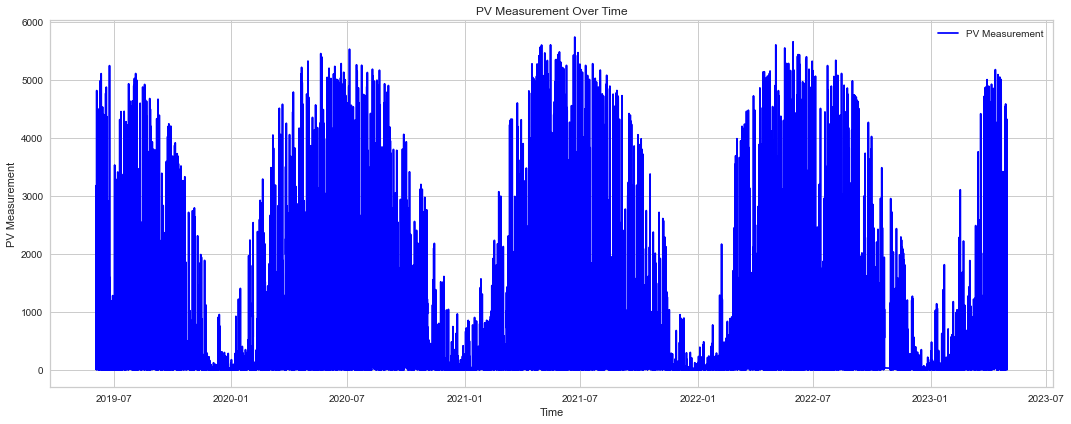

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (18038, 54)
4        Transformed data shape  (18038, 66)
5   Transformed train set shape  (12626, 66)
6    Transformed test set shape   (5412, 66)
7              Ordinal features            1
8              Numeric features           50
9          Categorical features            3
10     Rows with missing values        19.9%
11                   Preprocess         True
12              Imputation type       simple
13           Numeric imputation         mean
14       Categorical imputation         mode
15     Maximum one-hot encoding           25
16              Encoding method         None
17               Fold Generator        KFold
18                  Fold Number           10
19                     CPU Jobs           -1
20                      Use GPU        False
21        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     343.1896  281629.9252  530.6882  0.8407  0.9117  4.1828
1     305.0061  253285.3063  503.2746  0.8540  0.8599  2.6060
2     325.3754  277184.8739  526.4835  0.8493  0.8906  2.5567
3     342.7367  298598.9209  546.4421  0.8480  0.8479  2.8009
4     337.2962  294116.3854  542.3250  0.8348  0.8778  2.3554
5     351.0703  319241.1374  565.0143  0.8354  0.8084  1.7452
6     330.7766  286849.3129  535.5832  0.8479  0.8253  1.9725
7     341.0087  316699.0482  562.7602  0.8426  0.8577  2.5483
8     319.1093  271248.9254  520.8156  0.8516  0.8803  3.1128
9     342.4312  315338.1810  561.5498  0.8459  0.8630  2.8800
Mean  333.8000  291419.2017  539.4936  0.8450  0.8623  2.6761
Std    13.1529   20553.4314   19.1264  0.0062  0.0288  0.6339


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     332.7774  270349.9019  519.9518  0.8471  0.9262  4.9458
1     304.8743  245388.5184  495.3671  0.8586  0.8975  2.7863
2     323.9837  275618.4254  524.9937  0.8502  0.9214  2.9048
3     339.9517  301737.3548  549.3062  0.8464  0.8868  3.5801
4     336.0920  294251.8741  542.4499  0.8347  0.8744  2.5806
5     342.0899  306262.4364  553.4098  0.8421  0.8770  2.6410
6     325.4676  285466.4809  534.2906  0.8486  0.8544  2.5237
7     333.0848  301173.8213  548.7931  0.8503  0.9029  3.1106
8     326.1621  276669.2141  525.9935  0.8487  0.9029  3.1936
9     335.3457  309965.5504  556.7455  0.8485  0.8792  3.0849
Mean  329.9829  286688.3578  535.1301  0.8475  0.8923  3.1351
Std    10.1533   19014.5247   18.0028  0.0058  0.0211  0.6770


Processing:  83%|████████▎ | 5/6 [07:20<01:28, 88.02s/it]

In [16]:
# LightGBM training and predictions
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Calling preprocessing
    X_train_1, X_test_1, is_day_feature_1, targets_1 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    # Adding the extra features to the test set as well
    X_train_1 = X_train_1.drop(columns=['date_forecast'])
    X_test_1['weighted_rad'] = ((X_test_1['direct_rad:W'] * (1 - X_test_1['total_cloud_cover:p']/100)) +
                        (X_test_1['diffuse_rad:W'] * (X_test_1['total_cloud_cover:p']/100)))

    X_test_1['adjusted_clear_sky_rad'] = (X_test_1['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * X_test_1['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (X_test_1['air_density_2m:kgm3'] - 1.225)))
    
    # Training and prediction for diffrent seeds
    total_predictions_light = None
    seeds = [123]
    for seed in seeds: 
        final_model_lGBM_e = process_location_ex(X_train_1, targets_1, loc, seed)
        predictions_lGBM_e = predict_model(final_model_lGBM_e, data=X_test_1)
        final_predictions_lGBM_e = predictions_lGBM_e['prediction_label']
        if total_predictions_light is None:
            total_predictions_light = np.zeros_like(final_predictions_lGBM_e)
        total_predictions_light += final_predictions_lGBM_e

    mean_pred_light = total_predictions_light/len(seeds)

    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_lGBM_e = mean_pred_light * is_day_feature_1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_lGBM_e = np.clip(adjusted_final_predictions_lGBM_e, 0, None)

    # Appening predictions for each location to final list
    all_predictions_lGBM_e.append([adjusted_final_predictions_lGBM_e])

# Changing final list to array
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e)

### Catboost model nr 1

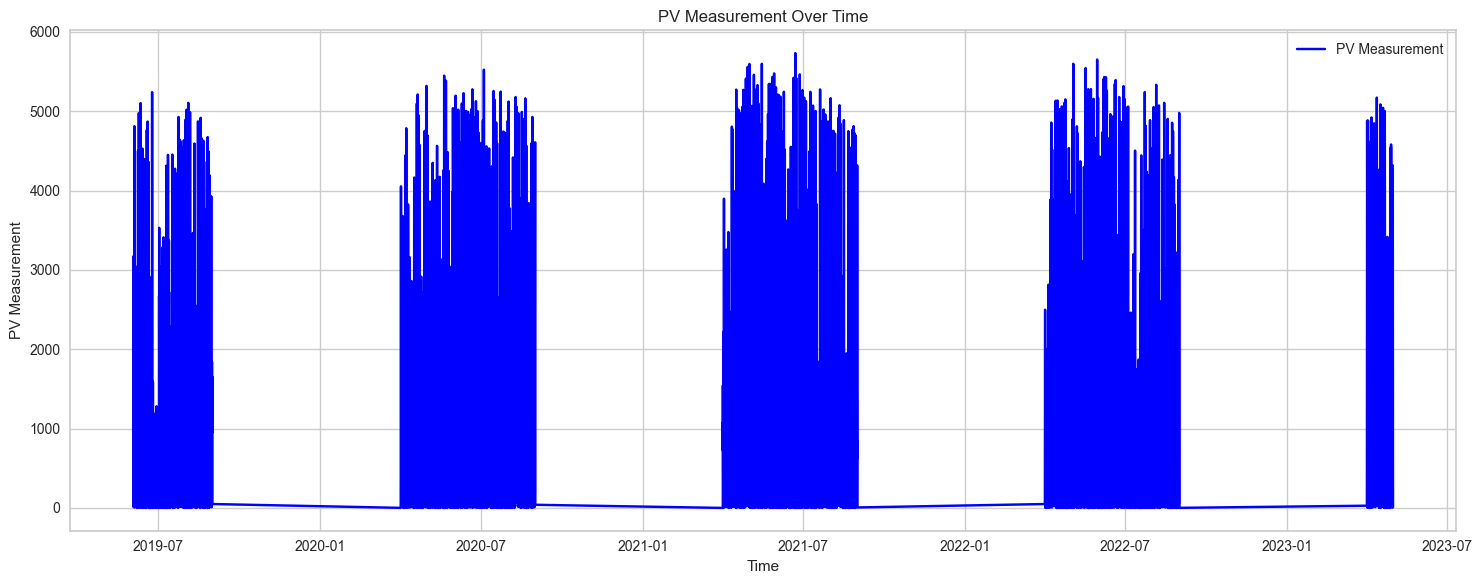

0:	learn: 1133.1485977	test: 1161.8801848	best: 1161.8801848 (0)	total: 179ms	remaining: 59m 35s
200:	learn: 380.7832197	test: 407.9747065	best: 407.9668233 (199)	total: 10.3s	remaining: 16m 58s
400:	learn: 352.2324282	test: 395.5890658	best: 395.4696379 (399)	total: 20.2s	remaining: 16m 25s
600:	learn: 331.7887963	test: 388.7446094	best: 388.7446094 (600)	total: 29.9s	remaining: 16m 3s
800:	learn: 315.8659408	test: 383.1824376	best: 383.1824376 (800)	total: 39.6s	remaining: 15m 49s
1000:	learn: 302.4346619	test: 380.2717965	best: 380.2717965 (1000)	total: 49.1s	remaining: 15m 32s
1200:	learn: 292.9005724	test: 377.7227363	best: 377.6904949 (1179)	total: 58.7s	remaining: 15m 18s
1400:	learn: 283.7778149	test: 375.3189635	best: 375.2656785 (1397)	total: 1m 8s	remaining: 15m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 374.3812485
bestIteration = 1518

Shrink model to first 1519 iterations.


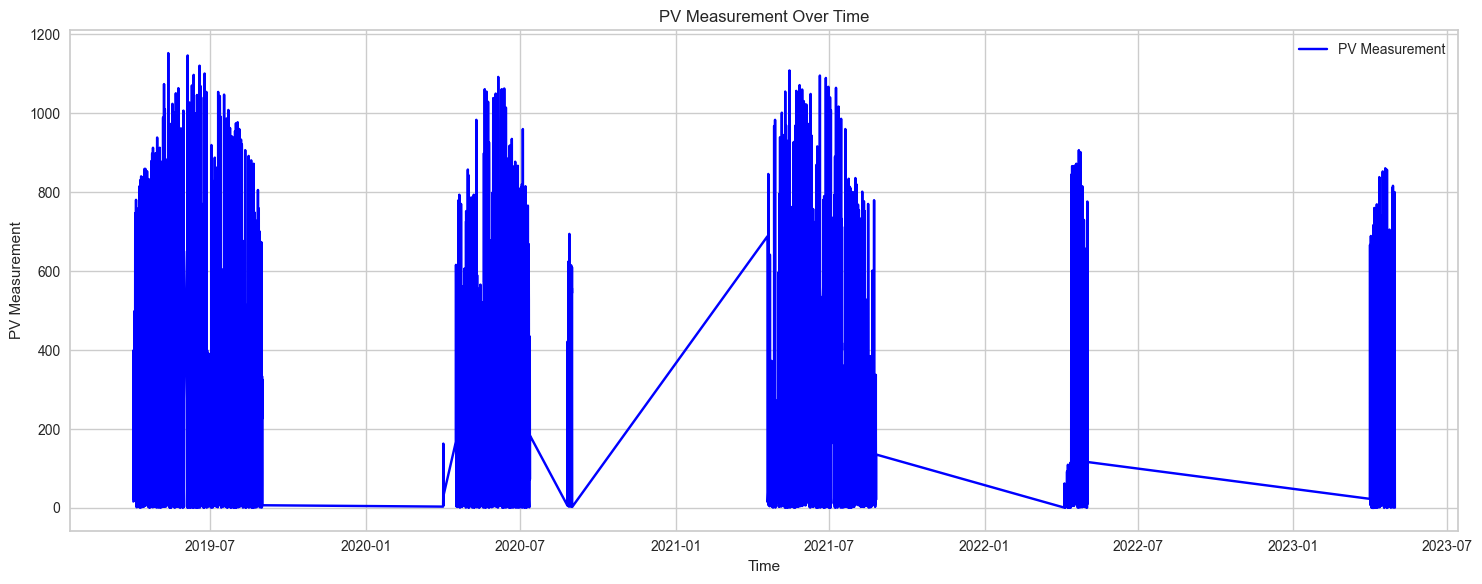

0:	learn: 226.8345310	test: 227.4857735	best: 227.4857735 (0)	total: 40.4ms	remaining: 13m 28s
200:	learn: 69.5482522	test: 71.7140617	best: 71.7140617 (200)	total: 9.29s	remaining: 15m 14s
400:	learn: 61.5946479	test: 68.8038454	best: 68.8038454 (400)	total: 18.7s	remaining: 15m 12s
600:	learn: 57.1013446	test: 67.5211639	best: 67.5211639 (600)	total: 27.9s	remaining: 15m 1s
800:	learn: 53.6494619	test: 66.8426356	best: 66.8426055 (799)	total: 37.2s	remaining: 14m 51s
1000:	learn: 50.9881275	test: 66.5981082	best: 66.5932065 (999)	total: 46.7s	remaining: 14m 47s
1200:	learn: 48.8739512	test: 66.1149302	best: 66.1145082 (1199)	total: 56.1s	remaining: 14m 38s
1400:	learn: 46.9791389	test: 65.9091962	best: 65.8939160 (1391)	total: 1m 5s	remaining: 14m 29s
1600:	learn: 45.3883026	test: 65.6822876	best: 65.6634544 (1565)	total: 1m 14s	remaining: 14m 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 65.66345436
bestIteration = 1565

Shrink model to first 1566 iterations.

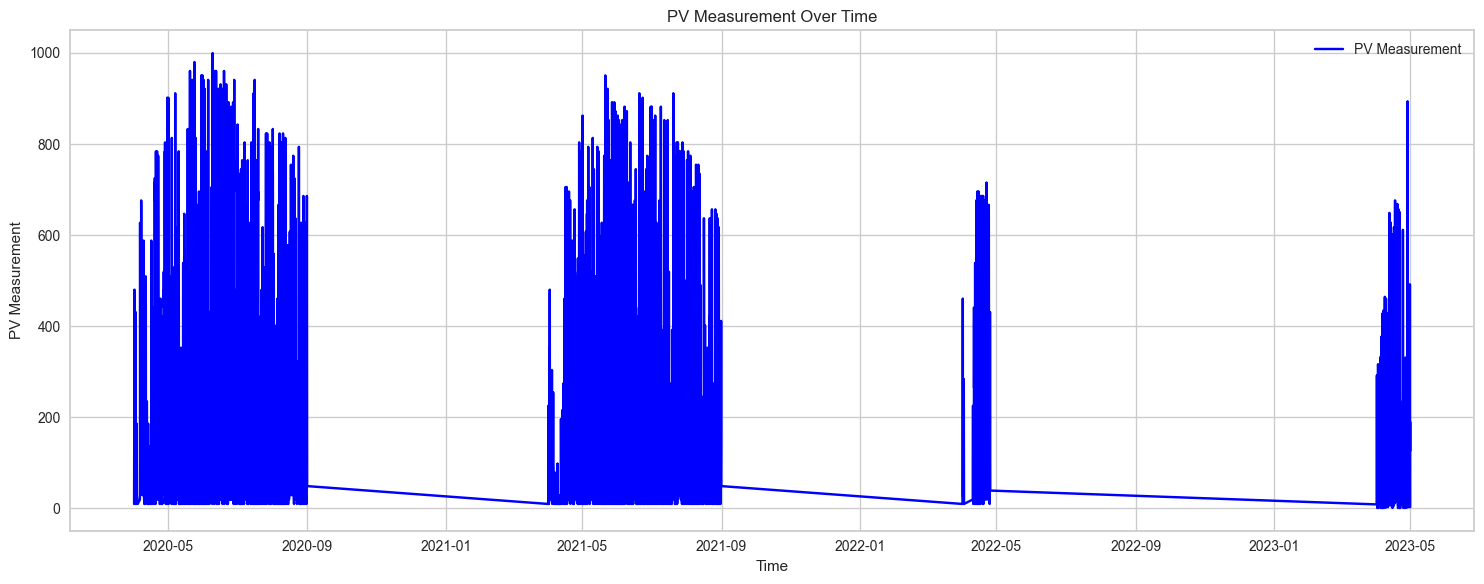

0:	learn: 188.2975532	test: 181.3608019	best: 181.3608019 (0)	total: 40.1ms	remaining: 13m 22s
200:	learn: 58.0048099	test: 63.4163503	best: 63.4163503 (200)	total: 9.47s	remaining: 15m 33s
400:	learn: 51.0181471	test: 61.2807264	best: 61.2807264 (400)	total: 18.8s	remaining: 15m 21s
600:	learn: 46.7772046	test: 59.7378117	best: 59.7378117 (600)	total: 28.1s	remaining: 15m 7s
800:	learn: 43.5408896	test: 59.0404435	best: 59.0377414 (799)	total: 37.7s	remaining: 15m 3s
1000:	learn: 40.7809692	test: 58.5538458	best: 58.5538458 (1000)	total: 47s	remaining: 14m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 58.46093379
bestIteration = 1031

Shrink model to first 1032 iterations.


In [ ]:
# Catboost model nr 1
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_cat, X_test_cat, is_day_feature1, targets_cat = preprocessing_cat(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Making categorical features
    cat_features = ['dew_or_rime:idx' ,'is_in_shadow:idx']
    X_train_cat['dew_or_rime:idx'] = X_train_cat['dew_or_rime:idx'].astype(int)
    X_train_cat['is_in_shadow:idx'] = X_train_cat['is_in_shadow:idx'].astype(int)
    X_test_cat['dew_or_rime:idx'] = X_test_cat['dew_or_rime:idx'].astype(int)
    X_test_cat['is_in_shadow:idx'] = X_test_cat['is_in_shadow:idx'].astype(int)

    # Catboooooooozt fun
    model_cat = CatBoostRegressor(
        loss_function='MAE', 
        learning_rate=0.05, 
        verbose=200,
        cat_features=cat_features,
        random_state=42, 
        n_estimators=20000,
        early_stopping_rounds=50,)

    X_train_cat1, X_val_cat1, y_train_cat1, y_val_cat1 = train_test_split(X_train_cat, targets_cat, test_size=0.2, random_state=42)
    
    # Training
    model_cat.fit(X_train_cat1, y_train_cat1['pv_measurement'],eval_set=(X_val_cat1, y_val_cat1['pv_measurement']),)

    # Prediction
    predictions_cat = model_cat.predict(X_test_cat)
    
    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat = predictions_cat * is_day_feature1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat = np.clip(adjusted_final_predictions_cat, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat.append(adjusted_final_predictions_cat)

# Changing final list to array
all_predictions_cat = np.array(all_predictions_cat)

### Catboost model nr 2

In [ ]:
# Catboost model nr 2
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping some winter months
    X_train_cat_2 = X_train[X_train['date_forecast'].dt.month.isin([3,4, 5, 6, 7, 8, 9,10])]

    # Dropping date feature
    X_train_cat_2 = X_train_cat_2.drop(columns=['date_forecast'])

    # Training and prediction for diffrent seeds
    seeds = [123]
    total_predictions_cat_2 = None
    for seed in seeds: 
        final_model_cat_2 = process_location_cat_2(X_train_cat_2, targets, loc,seed)#its aactually a catboost wohoo
        predictions_cat_2 = predict_model(final_model_cat_2, X_test)
        final_predictions_cat_2 = predictions_cat_2['prediction_label']
        if total_predictions_cat_2 is None:
            total_predictions_cat_2 = np.zeros_like(final_predictions_cat_2)
            total_predictions_cat_2+=final_predictions_cat_2

    mean_pred_cat_2 = total_predictions_cat_2/len(seeds)

    adjusted_final_predictions_cat_2 = mean_pred_cat_2 * is_day_feature['is_day:idx']
    adjusted_final_predictions_cat_2 = np.clip(adjusted_final_predictions_cat_2, 0, None)
    all_predictions_cat_2.append([adjusted_final_predictions_cat_2])
all_predictions_cat_2 = np.array(all_predictions_cat_2)

### Catboost model nr 3

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


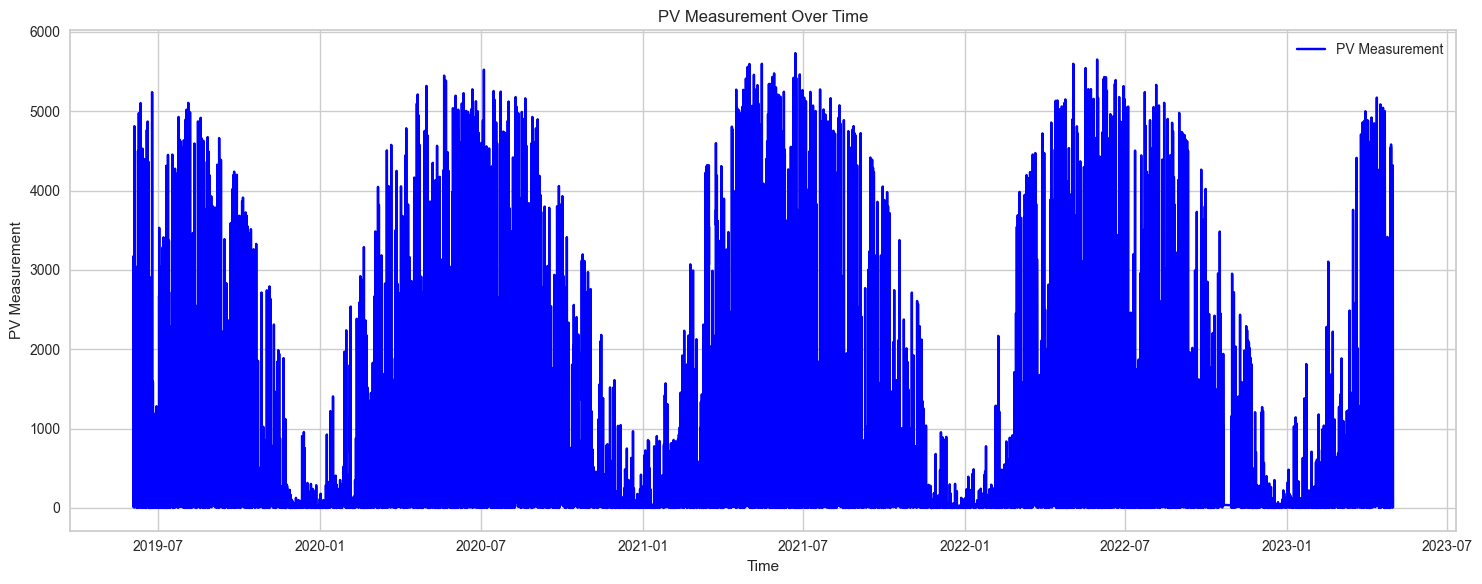

0     2023-05-01 00:00:00
1     2023-05-01 01:00:00
2     2023-05-01 02:00:00
3     2023-05-01 03:00:00
4     2023-05-01 04:00:00
5     2023-05-01 05:00:00
6     2023-05-01 06:00:00
7     2023-05-01 07:00:00
8     2023-05-01 08:00:00
9     2023-05-01 09:00:00
10    2023-05-01 10:00:00
11    2023-05-01 11:00:00
12    2023-05-01 12:00:00
13    2023-05-01 13:00:00
14    2023-05-01 14:00:00
15    2023-05-01 15:00:00
16    2023-05-01 16:00:00
17    2023-05-01 17:00:00
18    2023-05-01 18:00:00
19    2023-05-01 19:00:00
20    2023-05-01 20:00:00
21    2023-05-01 21:00:00
22    2023-05-01 22:00:00
23    2023-05-01 23:00:00
24    2023-05-06 00:00:00
25    2023-05-06 01:00:00
26    2023-05-06 02:00:00
27    2023-05-06 03:00:00
28    2023-05-06 04:00:00
29    2023-05-06 05:00:00
30    2023-05-06 06:00:00
31    2023-05-06 07:00:00
32    2023-05-06 08:00:00
33    2023-05-06 09:00:00
34    2023-05-06 10:00:00
35    2023-05-06 11:00:00
36    2023-05-06 12:00:00
37    2023-05-06 13:00:00
38    2023-0

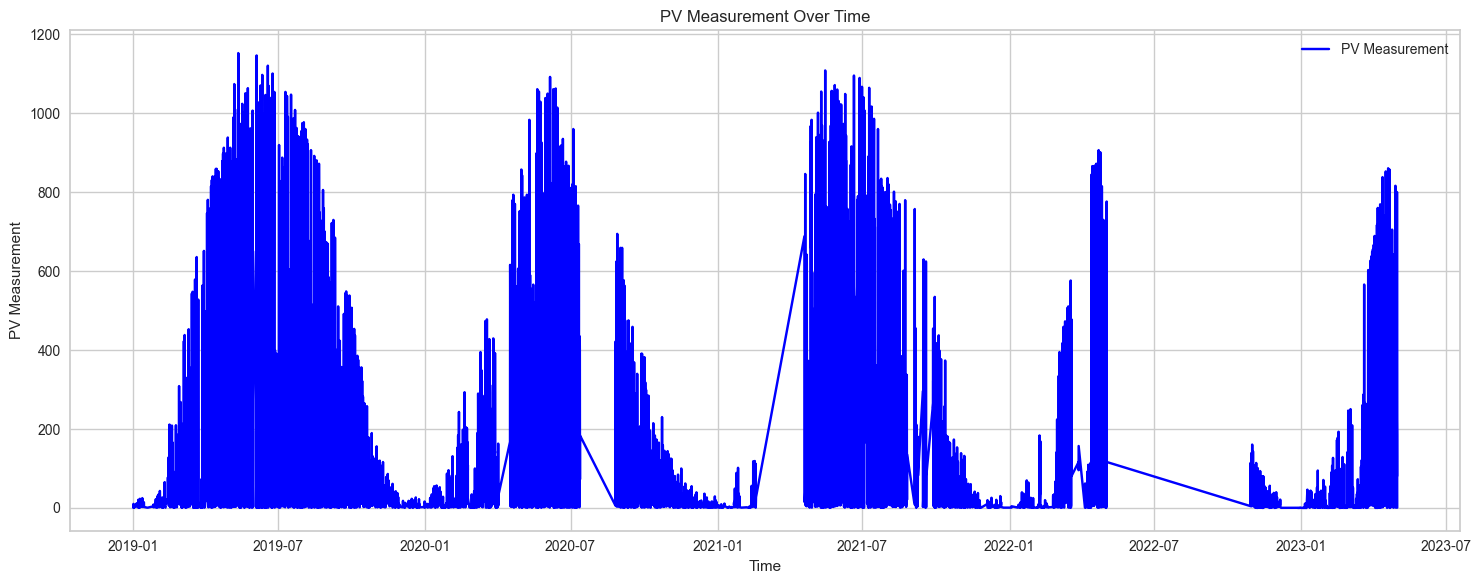

0     2023-05-01 00:00:00
1     2023-05-01 01:00:00
2     2023-05-01 02:00:00
3     2023-05-01 03:00:00
4     2023-05-01 04:00:00
5     2023-05-01 05:00:00
6     2023-05-01 06:00:00
7     2023-05-01 07:00:00
8     2023-05-01 08:00:00
9     2023-05-01 09:00:00
10    2023-05-01 10:00:00
11    2023-05-01 11:00:00
12    2023-05-01 12:00:00
13    2023-05-01 13:00:00
14    2023-05-01 14:00:00
15    2023-05-01 15:00:00
16    2023-05-01 16:00:00
17    2023-05-01 17:00:00
18    2023-05-01 18:00:00
19    2023-05-01 19:00:00
20    2023-05-01 20:00:00
21    2023-05-01 21:00:00
22    2023-05-01 22:00:00
23    2023-05-01 23:00:00
24    2023-05-06 00:00:00
25    2023-05-06 01:00:00
26    2023-05-06 02:00:00
27    2023-05-06 03:00:00
28    2023-05-06 04:00:00
29    2023-05-06 05:00:00
30    2023-05-06 06:00:00
31    2023-05-06 07:00:00
32    2023-05-06 08:00:00
33    2023-05-06 09:00:00
34    2023-05-06 10:00:00
35    2023-05-06 11:00:00
36    2023-05-06 12:00:00
37    2023-05-06 13:00:00
38    2023-0

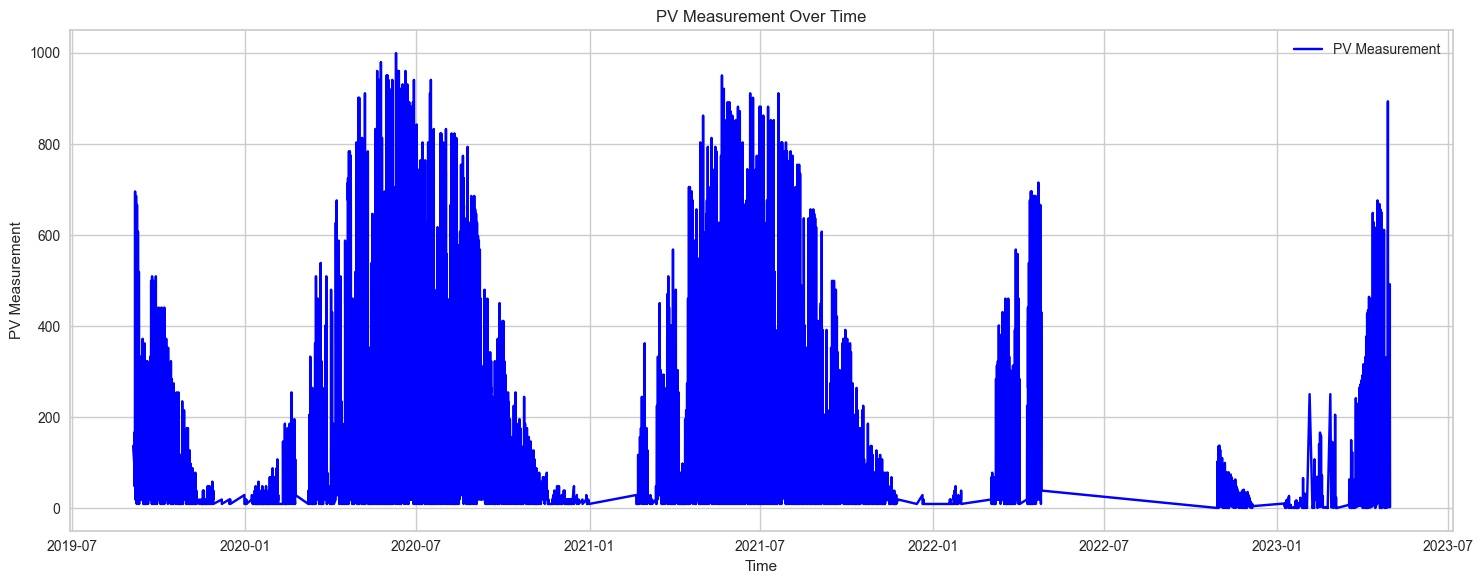

0     2023-05-01 00:00:00
1     2023-05-01 01:00:00
2     2023-05-01 02:00:00
3     2023-05-01 03:00:00
4     2023-05-01 04:00:00
5     2023-05-01 05:00:00
6     2023-05-01 06:00:00
7     2023-05-01 07:00:00
8     2023-05-01 08:00:00
9     2023-05-01 09:00:00
10    2023-05-01 10:00:00
11    2023-05-01 11:00:00
12    2023-05-01 12:00:00
13    2023-05-01 13:00:00
14    2023-05-01 14:00:00
15    2023-05-01 15:00:00
16    2023-05-01 16:00:00
17    2023-05-01 17:00:00
18    2023-05-01 18:00:00
19    2023-05-01 19:00:00
20    2023-05-01 20:00:00
21    2023-05-01 21:00:00
22    2023-05-01 22:00:00
23    2023-05-01 23:00:00
24    2023-05-06 00:00:00
25    2023-05-06 01:00:00
26    2023-05-06 02:00:00
27    2023-05-06 03:00:00
28    2023-05-06 04:00:00
29    2023-05-06 05:00:00
30    2023-05-06 06:00:00
31    2023-05-06 07:00:00
32    2023-05-06 08:00:00
33    2023-05-06 09:00:00
34    2023-05-06 10:00:00
35    2023-05-06 11:00:00
36    2023-05-06 12:00:00
37    2023-05-06 13:00:00
38    2023-0

In [ ]:
# Catboost model nr 3
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_3, X_test_3, is_day_feature_3, targets_3 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping date feature
    X_train_3 = X_train_3.drop(columns=['date_forecast'])
    
    # Catboooooooozt fun round 3 wohoo
    model_cat_3 = CatBoostRegressor(
    verbose=200, 
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=5,
    random_state=42, 
    n_estimators=20000, 
    loss_function='MAE', 
    early_stopping_rounds=100,)

    # Create 'sin_sun_azimuth' and 'cos_sun_azimuth' from 'sun_azimuth' in radians
    X_train_3['sin_sun_azimuth'] = np.sin(np.radians(X_train_3['sun_azimuth:d']))
    X_train_3['cos_sun_azimuth'] = np.cos(np.radians(X_train_3['sun_azimuth:d']))
    X_test_3['sin_sun_azimuth'] = np.sin(np.radians(X_test_3['sun_azimuth:d']))
    X_test_3['cos_sun_azimuth'] = np.cos(np.radians(X_test_3['sun_azimuth:d']))

    # Now drop the original 'sun_azimuth' feature
    X_train_3.drop('sun_azimuth:d', axis=1, inplace=True)
    X_test_3.drop('sun_azimuth:d', axis=1, inplace=True)

    # Split the training data into training and validation sets
    X_train_cat_3, X_test_cat_3, y_train_cat_3, y_test_cat_3 = train_test_split(X_train_3, targets_3, test_size=0.2, random_state=42)

    # Train model
    model_cat_3.fit(X_train_cat_3, y_train_cat_3['pv_measurement'],eval_set=(X_test_cat_3, y_test_cat_3['pv_measurement']),)  
    
    # Pred
    pred_cat_3 = model_cat_3.predict(X_test_3)

    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat_3 = pred_cat_3 * is_day_feature_3['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat_3 = np.clip(adjusted_final_predictions_cat_3, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat_3.append(adjusted_final_predictions_cat_3) 

# Changing final list to array   
all_predictions_cat_3 = np.array(all_predictions_cat_3)

### Random forest model

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


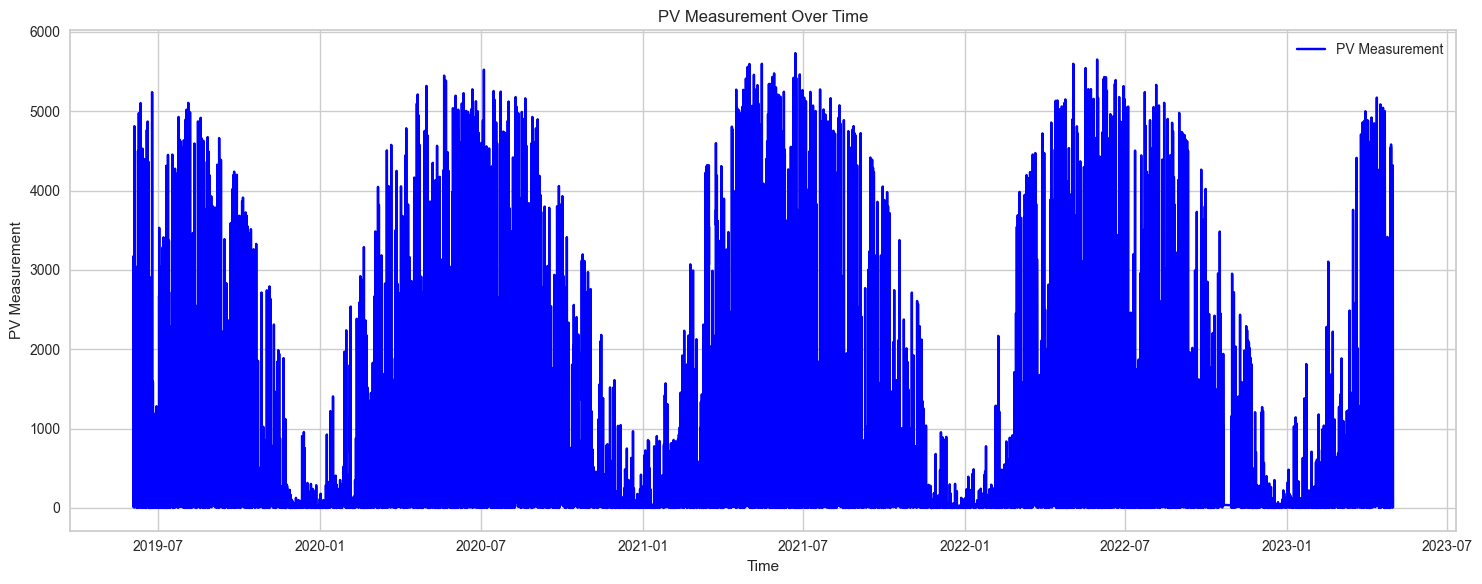

0     2023-05-01 00:00:00
1     2023-05-01 01:00:00
2     2023-05-01 02:00:00
3     2023-05-01 03:00:00
4     2023-05-01 04:00:00
5     2023-05-01 05:00:00
6     2023-05-01 06:00:00
7     2023-05-01 07:00:00
8     2023-05-01 08:00:00
9     2023-05-01 09:00:00
10    2023-05-01 10:00:00
11    2023-05-01 11:00:00
12    2023-05-01 12:00:00
13    2023-05-01 13:00:00
14    2023-05-01 14:00:00
15    2023-05-01 15:00:00
16    2023-05-01 16:00:00
17    2023-05-01 17:00:00
18    2023-05-01 18:00:00
19    2023-05-01 19:00:00
20    2023-05-01 20:00:00
21    2023-05-01 21:00:00
22    2023-05-01 22:00:00
23    2023-05-01 23:00:00
24    2023-05-06 00:00:00
25    2023-05-06 01:00:00
26    2023-05-06 02:00:00
27    2023-05-06 03:00:00
28    2023-05-06 04:00:00
29    2023-05-06 05:00:00
30    2023-05-06 06:00:00
31    2023-05-06 07:00:00
32    2023-05-06 08:00:00
33    2023-05-06 09:00:00
34    2023-05-06 10:00:00
35    2023-05-06 11:00:00
36    2023-05-06 12:00:00
37    2023-05-06 13:00:00
38    2023-0

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     382.6635  374253.0195  611.7622  0.8059  0.5803  0.8330
1     385.3473  370838.1778  608.9648  0.8255  0.6183  1.1285
2     376.2969  355207.9221  595.9932  0.8353  0.6118  0.9036
3     394.0273  379629.9249  616.1412  0.8303  0.6035  0.8105
4     392.2871  369224.8572  607.6388  0.8326  0.6622  1.4119
5     383.6170  353936.6879  594.9258  0.8352  0.6404  1.0071
6     375.3479  333433.8260  577.4373  0.8400  0.6266  0.9326
7     414.0942  429068.2293  655.0330  0.8079  0.6106  1.1142
8     404.4677  422992.8411  650.3790  0.8054  0.6580  1.2091
9     396.9308  403158.4095  634.9476  0.8045  0.6485  0.9230
Mean  390.5080  379174.3895  615.3223  0.8223  0.6260  1.0273
Std    11.7278   29122.3805   23.5133  0.0138  0.0248  0.1786


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# Random forest model
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
   
    '''train_non_zero = train[train['pv_measurement'] != 0]
    if train_non_zero.empty:
        print(f"train_non_zero is empty for location {loc}")

    # Get the timestamps of these rows
    valid_timestamps = train_non_zero['time'].tolist()
    
    # Filter the X_* dataframes based on these timestamps
    X_train_estimated = X_train_estimated[X_train_estimated['date_forecast'].isin(valid_timestamps)]
    X_train_observed = X_train_observed[X_train_observed['date_forecast'].isin(valid_timestamps)]
    #X_test_estimated = X_test_estimated[X_test_estimated['date_forecast'].isin(valid_timestamps)]
    if X_train_estimated.empty:
        print(f"X_train_estimated is empty for location {loc}")'''
    
    # Preprocess data
    #X_train_cat_2, X_test_cat_2, is_day_feature2, targets_cat_2 = preprocessing_cat_2(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    X_train_rf, X_test_rf, is_day_feature_rf, targets_rf = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    '''all_X_train_cat = pd.concat([all_X_train_cat, X_train_cat_2], ignore_index=True)
    all_X_test_cat = pd.concat([all_X_test_cat, X_test_cat_2], ignore_index=True)
    all_is_day_feature1 = pd.concat([all_is_day_feature1, is_day_feature2], ignore_index=True)
    all_targets_cat = pd.concat([all_targets_cat, targets_cat_2], ignore_index=True)'''
    
    # Filter observed and estimated data for April to August
    X_train_rf = X_train_rf[X_train_rf['date_forecast'].dt.month.isin([3, 4, 5, 6, 7, 8, 9])]
    
    #X_train_cat = X_train_cat[X_train_cat['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]    
    
    #X_train_cat = X_train_cat.drop(columns=['date_forecast'])
    X_train_rf = X_train_rf.drop(columns=['date_forecast'])
    
    X_train_rf['sin_sun_azimuth'] = np.sin(np.radians(X_train_rf['sun_azimuth:d']))
    X_train_rf['cos_sun_azimuth'] = np.cos(np.radians(X_train_rf['sun_azimuth:d']))
    X_test_rf['sin_sun_azimuth'] = np.sin(np.radians(X_test_rf['sun_azimuth:d']))
    X_test_rf['cos_sun_azimuth'] = np.cos(np.radians(X_test_rf['sun_azimuth:d']))

    # Now drop the original 'sun_azimuth' feature
    X_train_rf.drop('sun_azimuth:d', axis=1, inplace=True)
    X_test_rf.drop('sun_azimuth:d', axis=1, inplace=True)
    
    # Process the location data and get the final model
    '''stacked_model = process_location_stacked(X_train, X_train_cat, y_train, targets_cat, loc)
    pred_stacked = predict_model(stack_models, data = X_test)
    fin_pred_stacked = pred_stacked['prediction_label']
    ajust = fin_pred_stacked* is_day_feature['is_day:idx']
    ajust = np.clip(ajust, 0, None)
    all_pred_stacked.append([ajust])'''

    #final_model_lGBM = process_location(X_train, y_train, loc)
    X_test_1['weighted_rad'] = ((X_test_1['direct_rad:W'] * (1 - X_test_1['total_cloud_cover:p']/100)) +
                        (X_test_1['diffuse_rad:W'] * (X_test_1['total_cloud_cover:p']/100)))

    # Feature Combination 2: Atmospheric Conditions Combination
    X_test_1['adjusted_clear_sky_rad'] = (X_test_1['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * X_test_1['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (X_test_1['air_density_2m:kgm3'] - 1.225)))
    
    final_model_rf = process_location_rf(X_train_rf, targets_rf, loc)
    predictions_rf = predict_model(final_model_rf, data=X_test_rf)
    
    

   

    # time series spilt to spilt data for cat model
    

    def split_based_on_time(X, y, n_splits=6):
        
        ts = TimeSeriesSplit(n_splits=n_splits)
        for index, t_index in ts.split(X):
            pass  # Only using last spilt
        
        X_train, X_test = X.iloc[index], X.iloc[t_index]
        y_train, y_test = y.iloc[index], y.iloc[t_index]
        return X_train, X_test, y_train, y_test
    
    #X_train_cat_3, X_test_cat_3, y_train_cat_3, y_test_cat_3 = split_based_on_time(X_train_3, targets_3)
    #cat_models = train_multiple_catboost_models(X_train_cat, targets_cat['pv_measurement'], cat_features, seeds)
    
    
    # Ensemble the predictions
    #predictions_cat = ensemble_catboost_predictions(cat_models, X_test_cat)
    # Assuming 'predictions' is the output from predict_model
    #final_predictions_lGBM = predictions_lGBM['prediction_label']
    
    final_predictions_rf = predictions_rf['prediction_label']
    
    
    
    # Multiply final predictions with the 'is_day:idx' values
    #adjusted_final_predictions_lGBM = final_predictions_lGBM * is_day_feature['is_day:idx']
    adjusted_final_predictions_rf = final_predictions_rf * is_day_feature['is_day:idx']
    
    
    
    
    # Cliping values under zero to zero
    #adjusted_final_predictions_lGBM = np.clip(adjusted_final_predictions_lGBM, 0, None)
    
    adjusted_final_predictions_rf = np.clip(adjusted_final_predictions_rf, 0, None)
    
   
    
    # Store predictions
    #all_predictions_lGBM.append([adjusted_final_predictions_lGBM])
    
    all_predictions_rf.append([adjusted_final_predictions_rf]) 
     
     
    
    #til hit

    '''A = np.column_stack((all_predictions_lGBM[0],all_predictions_rf[0],all_predictions_lasso[0],all_predictions_cat[0]))
    meta_learner = LinearRegression().fit(stacked_predictions, true_values)
    model = sm.GLM(true_values, X, family=sm.families.Gaussian()).fit()'''

    '''# Prepare dataframe for visualization
    num_predictions = len(all_pred)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': all_pred['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)
'''

#Traing a cat model with all loc input

'''all_X_train_cat = all_X_train_cat.drop(columns=['date_forecast'])
final_model_cat_2 = process_location_cat_2(all_X_train_cat, all_targets_cat)
predictions_cat_2 = predict_model(final_model_cat_2, data=all_X_test_cat)
final_predictions_cat_2 = predictions_cat_2['prediction_label']
adjusted_final_predictions_cat_2 = final_predictions_cat_2 * all_is_day_feature1['is_day:idx']
adjusted_final_predictions_cat_2 = np.clip(adjusted_final_predictions_cat_2, 0, None)
all_predictions_cat_2 = adjusted_final_predictions_cat_2'''
#all_predictions_lGBM = np.array(all_predictions_lGBM)
#all_predictions_lGBM_e = np.array(all_predictions_lGBM_e)
all_predictions_rf = np.array(all_predictions_rf)
'''all_predictions_lasso = np.array(all_predictions_lasso)


all_pred = 0.3*all_predictions_cat+0.35 * all_predictions_lGBM_e+ 0.35* all_predictions_lasso'''

'''
# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])'''


# Combining Model Predictions

In [ ]:
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e).flatten()
all_predictions_rf = np.array(all_predictions_rf).flatten()
all_predictions_lasso = np.array(all_predictions_lasso).flatten()
all_predictions_cat = np.array(all_predictions_cat).flatten()
all_predictions_cat_3 = np.array(all_predictions_cat_3).flatten()
#all_predictions_cat_2 = np.array(all_predictions_cat_2).flatten()'''
#all_pred_stacked = np.array(all_pred_stacked).flatten()
all_pred = 0.2*all_predictions_cat+0.25 * all_predictions_lGBM_e+ 0.2* all_predictions_lasso+0.25*all_predictions_cat_3+ 0.1*all_predictions_rf#+ 0.45*all_predictions_lGBM  +  0.1*all_predictions_cat + 0.25*all_predictions_lasso + 0.1*all_predictions_rf
#all_pred = all_predictions_rf
print(all_pred.shape)

(2160,)


In [ ]:
print(X_test.shape)

(720, 51)


#### Saving the final predictions to CSV

In [ ]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)

In [ ]:
# Function to get the next run_id
def get_next_run_id():
    
    counter_file = 'run_counter.txt'

    if not os.path.exists(counter_file):
        with open(counter_file, 'w') as file:
            file.write('1')
            return 'run1'

    with open(counter_file, 'r') as file:
        current_count = int(file.read())

    new_run_id = f"run{current_count}"

    with open(counter_file, 'w') as file:
        file.write(str(current_count + 1))

    return new_run_id

# Get the next run_id
run_id = get_next_run_id()

# Save the predictions to a CSV, including the run_id in the filename
save.to_csv(f'predictions_{run_id}.csv')

NameError: name 'save' is not defined

#### Plotting and Comparing Time-Series Predictions for Multiple Locations

In [ ]:
# Plotting and Comparing Time-Series Predictions for Multiple Locations

# Directory where the prediction files are saved
pred_dir = os.getcwd()

# Compile a regular expression pattern to match prediction files with a specific naming pattern
regex = re.compile(r'predictions_run\d+.*\.csv$')

# List all prediction CSV files in the directory that match the pattern
pred_files = [f for f in os.listdir(pred_dir) if regex.match(f)]

# Create a dictionary of dataframes, each containing data from the prediction files
dfs = {}
for file in pred_files:
    key = file.replace('.csv', '')  
    dfs[key] = pd.read_csv(os.path.join(pred_dir, file))

# Assuming all prediction files have the same locations
locations = dfs[list(dfs.keys())[0]]['location'].unique()

# Define a color palette
colors = plt.cm.tab10.colors 

# Start plotting comparison graphs for each unique location
for loc in locations:
    plt.figure(figsize=(12, 6))
    color_idx = 0  # Create a cycle iterator
    
    # Plot each dataframe on the same plot
    for run_id, df in dfs.items():
        temp_df = df[df['location'] == loc]
        plt.plot(temp_df['time'], temp_df['prediction'], label=f'{run_id} for Location {loc}', color=colors[color_idx])
        color_idx = (color_idx + 1) % len(colors)
        
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    
    # Save the comparison figure
    plt.savefig(f'Location_{loc}_comparisons.png')
    plt.close()
